In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from obspy.taup import TauPyModel
from obspy.geodetics import degrees2kilometers, kilometer2degrees, gps2dist_azimuth
from mudpy import fakequakes
from matplotlib.lines import Line2D
import matplotlib as mpl 
import matplotlib.colors as colors
from matplotlib.colors import Normalize

In [2]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [117]:
path = '/Users/sydneydybing/SW4/strain/experiments/'

## Dara's rupture model

## Change the rise time, keep the slip the same (homogeneous ruptures)

In [125]:
force_hypo_path = path + 'force_hypo/'
results_path = path + 'talapas/results/force_hypo/homogeneous/'

dirs_list = sorted((f for f in os.listdir(results_path) if not f.startswith('.')), key = str.lower)
# print(dirs_list)

models = dirs_list
print(models)

extra_stas = pd.read_csv(force_hypo_path + 'force_hypo_extra_stas_w_travel_times_azimuths_azgroups.csv')
extra_stas

['MH2017', 'MH2017+1', 'MH2017+2', 'MH2017-1']


,name,lon,lat,hypo_dist_km,p_arrival,azimuth,az_group,s_arrival
0,E1,-119.0,34.50,189.564786,29.020514,221.931378,45-90,51.913776
1,E2,-119.0,34.75,169.661378,26.579246,228.105464,45-90,47.503885
2,E3,-119.0,35.00,152.226967,24.339596,235.802081,45-90,43.070595
3,E4,-119.0,35.25,138.199839,22.283693,245.265444,45-90,39.268865
4,E5,-119.0,35.50,128.699697,20.891293,256.479578,45-90,36.670824
...,...,...,...,...,...,...,...,...
138,E139,-116.0,36.00,148.374615,23.774972,80.017542,225-270,42.034287
139,E140,-116.0,36.25,155.166856,24.770485,69.847071,225-270,43.841704
140,E141,-116.0,36.50,166.365391,26.174974,60.785682,225-270,46.773611
141,E142,-116.0,36.75,181.155434,27.989059,53.032311,225-270,50.050561


In [126]:
# Calculate maximum P-wave amplitude 

for model in models:
    
    max_p_amps = []
    extra_stas = pd.read_csv(force_hypo_path + 'force_hypo_extra_stas_w_travel_times_azimuths_azgroups.csv')
    model_path = results_path + model + '/results/'
    print(model_path)
    
    for i in range(len(extra_stas)):

        sta = extra_stas['name'].values[i]
        theo_p_arr = extra_stas['p_arrival'].values[i]
        theo_s_arr = extra_stas['s_arrival'].values[i]
        hypo_dist = extra_stas['hypo_dist_km'].values[i]
        az_diff = extra_stas['azimuth'].values[i]

        # print(sta)
        # print(theo_p_arr)
        # print(hypo_dist)

        strain_path = model_path + extra_stas['name'].values[i] + 's.txt'
        disp_path = model_path + extra_stas['name'].values[i] + 'd.txt'

        ### Process strain and gnss data ###

        time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain = process_strain(strain_path, theo_p_arr)
        time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss = process_disp(disp_path, theo_p_arr)

        # Calculate the maximum P-wave amplitude from the RMS data

        samp_rate = len(time_strain) / max(time_strain)
        # print(samp_rate)

        # plt.plot(time_strain, rms_strain)
        # plt.xlim(theo_p_arr-5, theo_s_arr-1)
        # plt.ylim(min(rms_strain[:int((theo_p_arr-5)*samp_rate)]), max(rms_strain[:int((theo_s_arr-1)*samp_rate)]))
        # plt.axvline(theo_p_arr, color = 'red')
        # plt.axvline(theo_s_arr-1, color = 'green')
        # plt.show()

        max_p_amp = max(rms_strain[int(theo_p_arr*samp_rate):int((theo_s_arr-1)*samp_rate)])
        # print(max_p_amp)
        max_p_amps.append(max_p_amp)

    extra_stas['max_p_amp'] = max_p_amps
    extra_stas.to_csv(force_hypo_path + 'radiation_patterns/csvs_w_p_amps/extra_stas_' + model + '.csv', index = False)
    

/Users/sydneydybing/SW4/strain/experiments/talapas/results/force_hypo/homogeneous/MH2017/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/force_hypo/homogeneous/MH2017+1/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/force_hypo/homogeneous/MH2017+2/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/force_hypo/homogeneous/MH2017-1/results/


MH2017


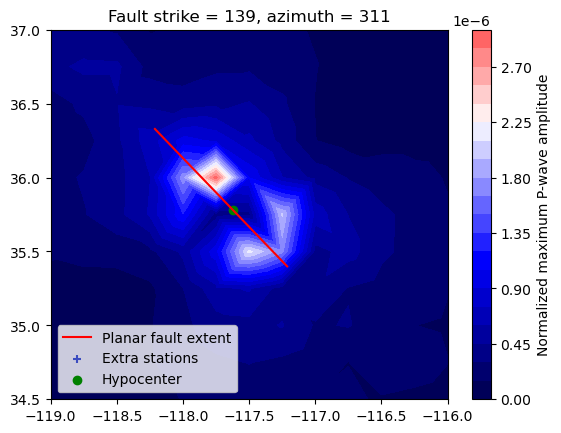

MH2017+1


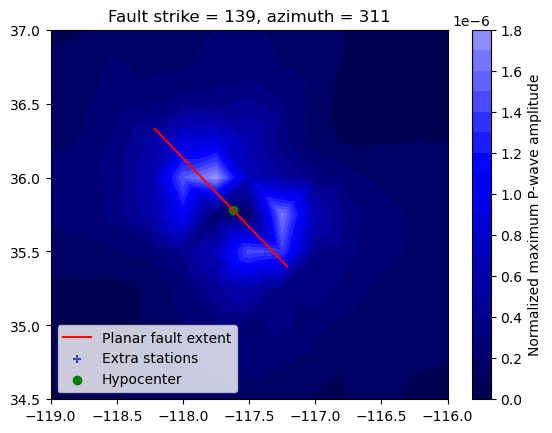

MH2017+2


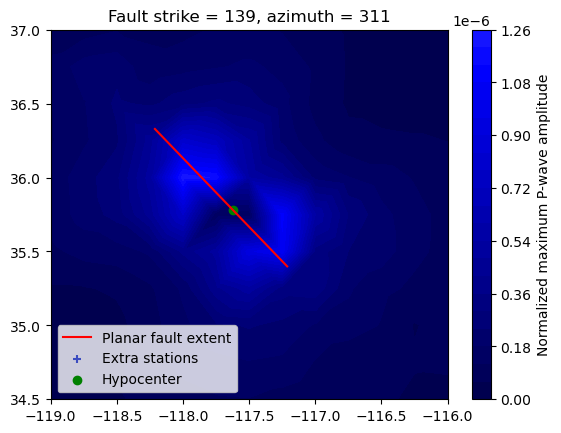

MH2017-1


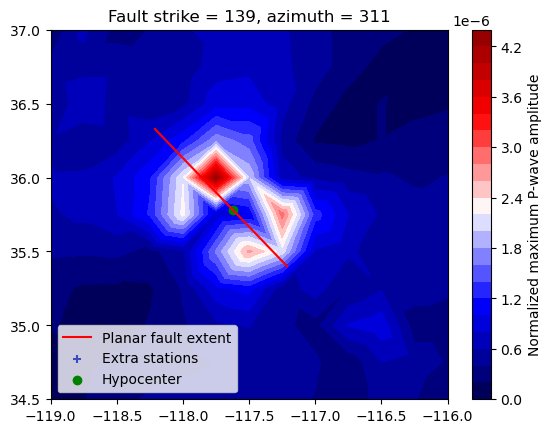

In [130]:
# Plot a normalized radiation pattern

for model in models:
    
    print(model)
    extra_stas = pd.read_csv(force_hypo_path + 'radiation_patterns/csvs_w_p_amps/extra_stas_' + model + '.csv')
    
    # Normalize the P-amplitudes between -1 and 1

#     low_a = -1
#     high_b = 1

#     min_amp = min(p_amps)
#     max_amp = max(p_amps)

#     amp_norm = low_a + (((p_amps - min_amp) * (high_b - low_a)) / (max_amp - min_amp))

#     # Check normalization
#     plt.hist(amp_norm)
#     plt.show()
    
    # Plot radiation pattern

    # Fault extent
    min_lon = -118.2123
    max_lon = -117.2121
    min_lat = 35.3989
    max_lat = 36.3284

    plt.title('Fault strike = 139, azimuth = 311')
    plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'red', label = 'Planar fault extent')   
    plt.scatter(extra_stas['lon'], extra_stas['lat'], marker = '+', c = extra_stas['max_p_amp'], vmin = 0.1*10**-5, vmax = 1*10**-5, cmap = 'coolwarm', label = 'Extra stations')
    # contour = plt.tricontourf(extra_stas['lon'].values, extra_stas['lat'].values, amp_norm, cmap = 'seismic', levels = 20)
    contour = plt.tricontourf(extra_stas['lon'].values, extra_stas['lat'].values, extra_stas['max_p_amp'].values, vmin = 0, vmax = 4.5*10**-6, cmap = 'seismic', levels = 20)
    plt.colorbar(contour, label = 'Normalized maximum P-wave amplitude')
    plt.scatter(hypo_lon, hypo_lat, color = 'green', label = 'Hypocenter')
    plt.legend(loc = 'lower left')
    plt.show()

## Change the slip amount, keep rise time the same (homogeneous ruptures)

In [116]:
change_slip_path = path + 'hold_rise_change_slip/'
results_path = path + 'talapas/results/hold_rise_change_slip/homogeneous/'

dirs_list = sorted((f for f in os.listdir(results_path) if not f.startswith('.')), key = str.lower)
# print(dirs_list)

models = dirs_list
print(models)

hypocenter = [-117.620771, 35.779107, 11.596]

hypo_lat = hypocenter[1]
hypo_lon = hypocenter[0]
hypo_depth = hypocenter[2]

['0.05_m_slip_Mw_6.5', '0.1_m_slip_Mw_6.7', '0.25_m_slip_Mw_6.9', '0.5_m_slip_Mw_7.1', '10_m_slip_Mw_8.0', '1_m_slip_Mw_7.3', '2_m_slip_Mw_7.5', '3_m_slip_Mw_7.6', '4_m_slip_Mw_7.7', '5_m_slip_Mw_7.8']


In [107]:
# Calculate maximum P-wave amplitude 

for model in models:
    
    max_p_amps = []
    extra_stas = pd.read_csv(change_slip_path + 'change_slip_extra_stas_w_travel_times_azimuths_azgroups.csv')
    model_path = results_path + model + '/results/'
    print(model_path)
    
    for i in range(len(extra_stas)):

        sta = extra_stas['name'].values[i]
        theo_p_arr = extra_stas['p_arrival'].values[i]
        theo_s_arr = extra_stas['s_arrival'].values[i]
        hypo_dist = extra_stas['hypo_dist_km'].values[i]
        az_diff = extra_stas['azimuth'].values[i]

        # print(sta)
        # print(theo_p_arr)
        # print(hypo_dist)

        strain_path = model_path + extra_stas['name'].values[i] + 's.txt'
        disp_path = model_path + extra_stas['name'].values[i] + 'd.txt'

        ### Process strain and gnss data ###

        time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain = process_strain(strain_path, theo_p_arr)
        time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss = process_disp(disp_path, theo_p_arr)

        # Calculate the maximum P-wave amplitude from the RMS data

        samp_rate = len(time_strain) / max(time_strain)
        # print(samp_rate)

        # plt.plot(time_strain, rms_strain)
        # plt.xlim(theo_p_arr-5, theo_s_arr-1)
        # plt.ylim(min(rms_strain[:int((theo_p_arr-5)*samp_rate)]), max(rms_strain[:int((theo_s_arr-1)*samp_rate)]))
        # plt.axvline(theo_p_arr, color = 'red')
        # plt.axvline(theo_s_arr-1, color = 'green')
        # plt.show()

        max_p_amp = max(rms_strain[int(theo_p_arr*samp_rate):int((theo_s_arr-1)*samp_rate)])
        # print(max_p_amp)
        max_p_amps.append(max_p_amp)

    extra_stas['max_p_amp'] = max_p_amps
    extra_stas.to_csv(change_slip_path + 'radiation_patterns/csvs_w_p_amps/extra_stas_' + model + '.csv', index = False)
    

/Users/sydneydybing/SW4/strain/experiments/talapas/results/hold_rise_change_slip/homogeneous/0.05_m_slip_Mw_6.5/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/hold_rise_change_slip/homogeneous/0.1_m_slip_Mw_6.7/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/hold_rise_change_slip/homogeneous/0.25_m_slip_Mw_6.9/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/hold_rise_change_slip/homogeneous/0.5_m_slip_Mw_7.1/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/hold_rise_change_slip/homogeneous/10_m_slip_Mw_8.0/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/hold_rise_change_slip/homogeneous/1_m_slip_Mw_7.3/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/hold_rise_change_slip/homogeneous/2_m_slip_Mw_7.5/results/
/Users/sydneydybing/SW4/strain/experiments/talapas/results/hold_rise_change_slip/homogeneous/3_m_slip_Mw_7.6/results/
/Users/sydneydybing/SW4/strain/experiments/ta

0.05_m_slip_Mw_6.5


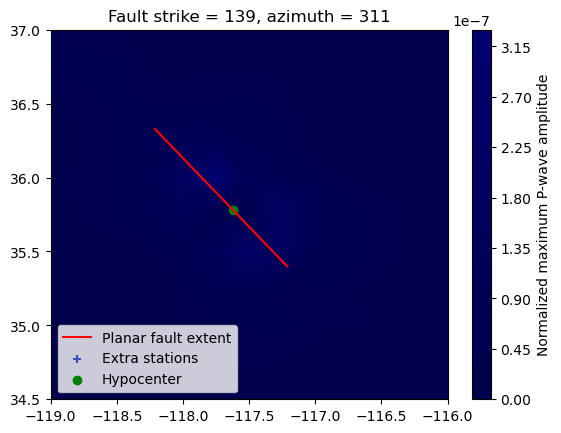

0.1_m_slip_Mw_6.7


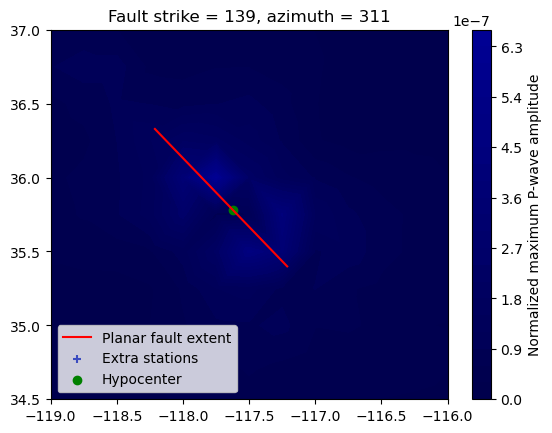

0.25_m_slip_Mw_6.9


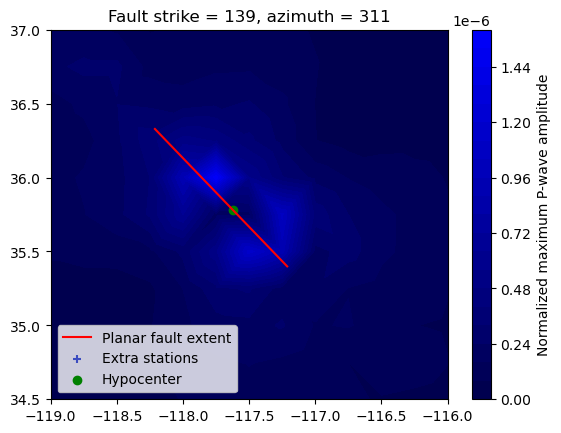

0.5_m_slip_Mw_7.1


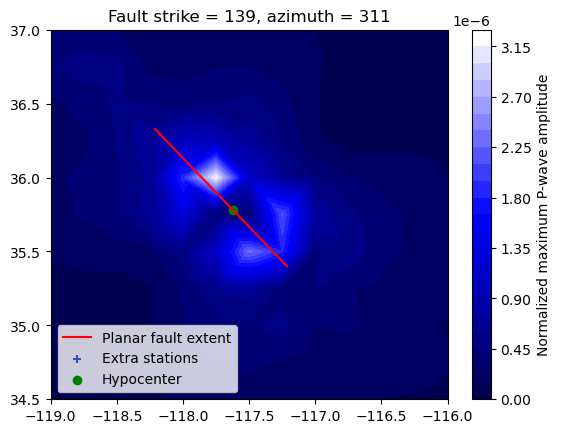

10_m_slip_Mw_8.0


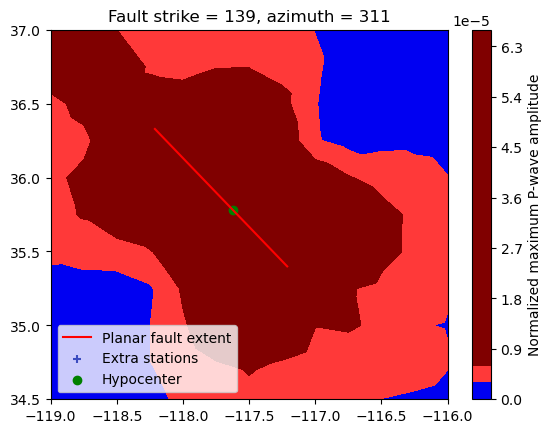

1_m_slip_Mw_7.3


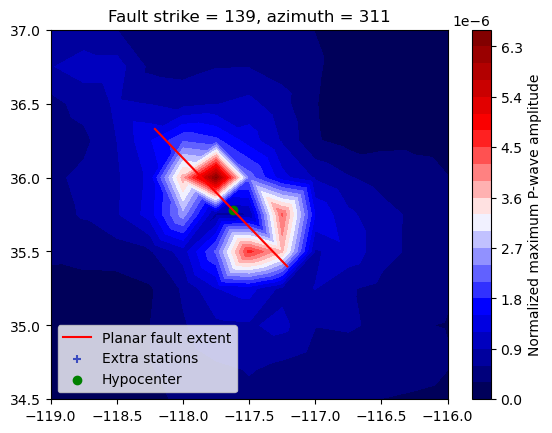

2_m_slip_Mw_7.5


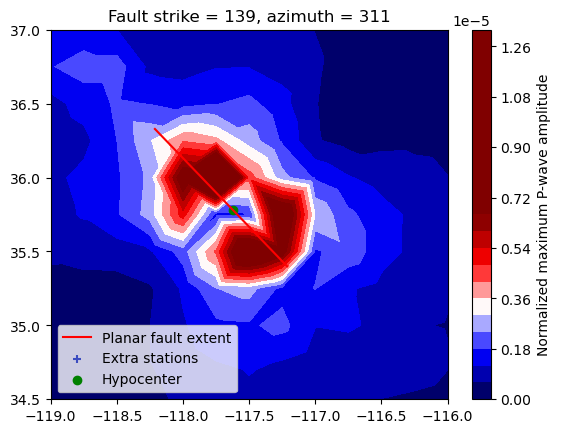

3_m_slip_Mw_7.6


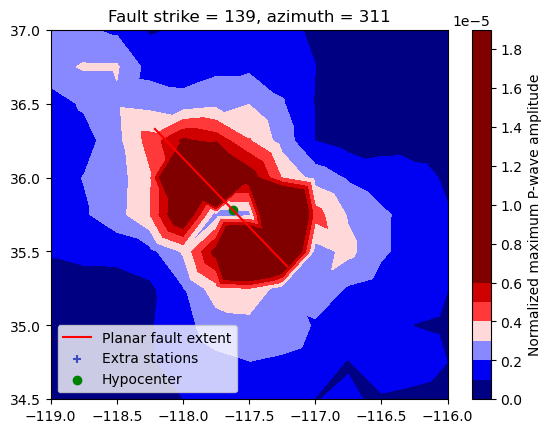

4_m_slip_Mw_7.7


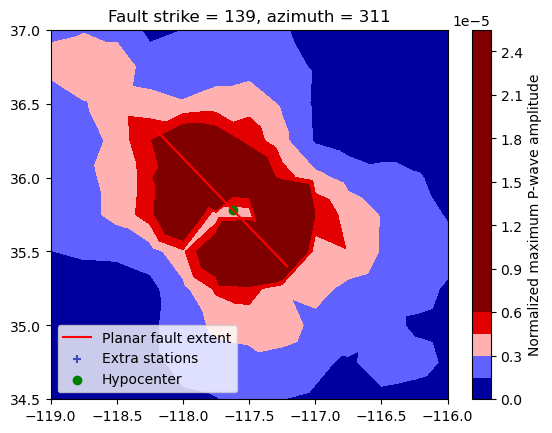

5_m_slip_Mw_7.8


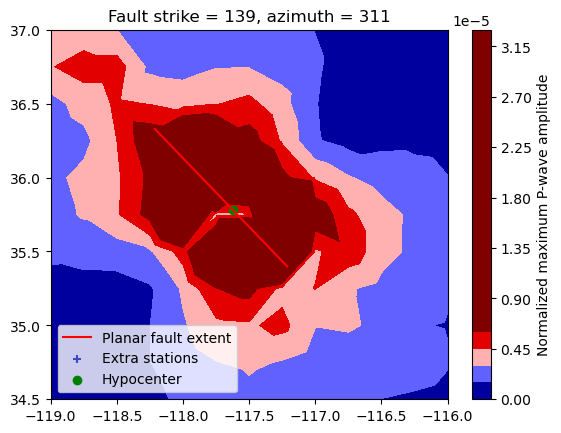

In [115]:
# Plot a normalized radiation pattern

for model in models:
    
    print(model)
    extra_stas = pd.read_csv(change_slip_path + 'radiation_patterns/csvs_w_p_amps/extra_stas_' + model + '.csv')
    
    # Normalize the P-amplitudes between -1 and 1

#     low_a = -1
#     high_b = 1

#     min_amp = min(p_amps)
#     max_amp = max(p_amps)

#     amp_norm = low_a + (((p_amps - min_amp) * (high_b - low_a)) / (max_amp - min_amp))

#     # Check normalization
#     plt.hist(amp_norm)
#     plt.show()
    
    # Plot radiation pattern

    # Fault extent
    min_lon = -118.2123
    max_lon = -117.2121
    min_lat = 35.3989
    max_lat = 36.3284

    plt.title('Fault strike = 139, azimuth = 311')
    plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'red', label = 'Planar fault extent')   
    plt.scatter(extra_stas['lon'], extra_stas['lat'], marker = '+', c = extra_stas['max_p_amp'], vmin = 0.1*10**-5, vmax = 1*10**-5, cmap = 'coolwarm', label = 'Extra stations')
    # contour = plt.tricontourf(extra_stas['lon'].values, extra_stas['lat'].values, amp_norm, cmap = 'seismic', levels = 20)
    contour = plt.tricontourf(extra_stas['lon'].values, extra_stas['lat'].values, extra_stas['max_p_amp'].values, vmin = 0, vmax = 6.5*10**-6, cmap = 'seismic', levels = 20)
    plt.colorbar(contour, label = 'Normalized maximum P-wave amplitude')
    plt.scatter(hypo_lon, hypo_lat, color = 'green', label = 'Hypocenter')
    plt.legend(loc = 'lower left')
    plt.show()

In [19]:
### Process strain data ###

def process_strain(strain_data, theoretical_p_arrival):
    
    strain = pd.read_csv(strain_path, sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])

    # Calculate horizontal RMS strain
    time_strain = strain.time.values
    xx_strain = strain.xx.values
    xy_strain = strain.xy.values
    yy_strain = strain.yy.values
    rms_strain = np.sqrt((xx_strain**2 + xy_strain**2 + yy_strain**2)/3)

    # Calculate peak strain
    strain_p_i = np.abs(time_strain - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_strain = rms_strain.copy()
    p_arr_strain = rms_strain[strain_p_i]
    mod_rms_strain[:strain_p_i] = p_arr_strain # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_strain = mod_rms_strain.copy()
    for k in range(0,len(mod_rms_strain)):
        if k == 0:
            strain = mod_rms_strain[0]
            max_strain = strain
        else:
            # Grab progressively longer windows and save the biggest strain
            strain = mod_rms_strain[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_strain = max(strain)
        # Put peak strain back into the output stream
        peak_strain[k] = max_strain 
    
    return time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain

### Process GNSS data to match the strain processing ###

def process_disp(disp_data, theoretical_p_arrival):
    
    disp = pd.read_csv(disp_path, sep = '\s+', skiprows = 13, names = ['time', 'x', 'y', 'z'])

    # Calculate horizontal RMS GNSS  
    time_gnss = disp.time.values
    x_gnss = disp.x.values
    y_gnss = disp.y.values
    rms_gnss = np.sqrt((x_gnss**2 + y_gnss**2)/2)

    # Calculate peak GNSS
    gnss_p_i = np.abs(time_gnss - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_gnss = rms_gnss.copy()
    p_arr_gnss = rms_gnss[gnss_p_i]
    mod_rms_gnss[:gnss_p_i] = p_arr_gnss # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_gnss = mod_rms_gnss.copy()
    for k in range(0,len(mod_rms_gnss)):
        if k == 0:
            gnss = mod_rms_gnss[0]
            max_gnss = gnss
        else:
            # Grab progressively longer windows and save the biggest strain
            gnss = mod_rms_gnss[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_gnss = max(gnss)
        # Put peak strain back into the output stream
        peak_gnss[k] = max_gnss 
    
    return time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss

In [31]:
# Calculate theoretical S-wave arrival times

# Make or load our custom TauPyModel format velocity model
custom_model = TauPyModel(model = path + 'mojave_simpletop_forsw4.npz')

# Add a column to each stations dataframe with the theoretical S-wave arrival times

# Extra station grid

extra_dists_km = []
extra_s_arr_times = []
extra_azs = []

for idx2 in range(len(extra_stas)):

    sta_lat = extra_stas['lat'].values[idx2]
    sta_lon = extra_stas['lon'].values[idx2]

    # print(sta_lat, sta_lon)

    dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters, az is angle in degrees from hypo to sta
    # print(round(dist_m/1000,1))

    arrivals = custom_model.get_travel_times(source_depth_in_km = hypo_depth, 
                                  distance_in_degree = kilometer2degrees(dist_m/1000), phase_list=['s', 'S'])
    s_arr_time = arrivals[0].time

    extra_s_arr_times.append(s_arr_time)
    extra_dists_km.append(dist_m/1000)
    extra_azs.append(az)

extra_stas['hypo_dist_km'] = extra_dists_km
extra_stas['s_arrival'] = extra_s_arr_times
extra_stas['azimuth'] = extra_azs

extra_stas.to_csv(force_hypo_path + 'force_hypo_extra_stas_w_travel_times_azimuths_azgroups.csv', index = False)


/var/folders/yg/s8qp7lfs59g_tbwsx_wxkdx80000gn/T/ipykernel_71840/2507306088.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters, az is angle in degrees from hypo to sta
